In [1]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from tensorflow.keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from tensorflow.keras import backend as Kb
from keras.layers import Lambda
from keras.layers import Activation
from keras.layers import add, concatenate
from keras.layers import AveragePooling2D
from keras.utils import plot_model
from keras.layers import AveragePooling3D

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
 
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from operator import truediv
 
from plotly.offline import init_notebook_mode
 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
!pip install spectral
import spectral

2024-07-11 19:29:52.875553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-11 19:29:52.902964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-11 19:29:52.903011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-11 19:29:52.922344: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 19:29:53.903591: W tensorflow/com


[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
def applyFA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    fa = FactorAnalysis(n_components=numComponents, random_state=0)
    newX = fa.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, fa

In [3]:
# def applyPCA(X, numComponents=75):
#     newX = np.reshape(X, (-1, X.shape[2]))
#     pca = PCA(n_components=numComponents, whiten=True)
#     newX = pca.fit_transform(newX)
#     newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
#     return newX, pca

In [4]:
## GLOBAL VARIABLES
dataset = 'SA'
test_ratio = 0.95
windowSize = 12

In [5]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [6]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [7]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [8]:
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    margin = int((windowSize) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin , c - margin:c + margin ]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [9]:
X, y = loadData(dataset)

X.shape, y.shape

((512, 217, 204), (512, 217))

In [10]:
K = X.shape[2]

In [11]:
K = 3 if dataset == 'IP' else 3
X,fa = applyFA(X,numComponents=K)

X.shape

(512, 217, 3)

In [12]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((54129, 12, 12, 3), (54129,))

In [13]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((2706, 12, 12, 3), (51423, 12, 12, 3), (2706,), (51423,))

In [14]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(2706, 12, 12, 3, 1)

In [15]:
ytrain = to_categorical(ytrain)
ytrain.shape

(2706, 16)

In [16]:
S1 = windowSize
L1 = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [17]:
def WaveletTransformAxisY(batch_img):
    odd_img  = batch_img[:,0::2]
    even_img = batch_img[:,1::2]
    L = (odd_img + even_img) / 2.0
    H = Kb.abs(odd_img - even_img)
    return L, H

def WaveletTransformAxisX(batch_img):
    # transpose + fliplr
    tmp_batch = Kb.permute_dimensions(batch_img, [0, 2, 1])[:,:,::-1]
    _dst_L, _dst_H = WaveletTransformAxisY(tmp_batch)
    # transpose + flipud
    dst_L = Kb.permute_dimensions(_dst_L, [0, 2, 1])[:,::-1,...]
    dst_H = Kb.permute_dimensions(_dst_H, [0, 2, 1])[:,::-1,...]
    return dst_L, dst_H

In [18]:
def Wavelet(batch_image):
    # make channel first image
    batch_image = Kb.permute_dimensions(batch_image, [0, 3, 1, 2])
    r = batch_image[:, 0]
    g = batch_image[:, 1]
    b = batch_image[:, 2]

    # level 1 decomposition
    wavelet_L, wavelet_H = WaveletTransformAxisY(r)
    r_wavelet_LL, r_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    r_wavelet_HL, r_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(g)
    g_wavelet_LL, g_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    g_wavelet_HL, g_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_L, wavelet_H = WaveletTransformAxisY(b)
    b_wavelet_LL, b_wavelet_LH = WaveletTransformAxisX(wavelet_L)
    b_wavelet_HL, b_wavelet_HH = WaveletTransformAxisX(wavelet_H)

    wavelet_data = [r_wavelet_LL, r_wavelet_LH, r_wavelet_HL, r_wavelet_HH, 
                    g_wavelet_LL, g_wavelet_LH, g_wavelet_HL, g_wavelet_HH,
                    b_wavelet_LL, b_wavelet_LH, b_wavelet_HL, b_wavelet_HH]
    transform_batch = Kb.stack(wavelet_data, axis=1)

    # level 2 decomposition
    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(r_wavelet_LL)
    r_wavelet_LL2, r_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    r_wavelet_HL2, r_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(g_wavelet_LL)
    g_wavelet_LL2, g_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    g_wavelet_HL2, g_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_L2, wavelet_H2 = WaveletTransformAxisY(b_wavelet_LL)
    b_wavelet_LL2, b_wavelet_LH2 = WaveletTransformAxisX(wavelet_L2)
    b_wavelet_HL2, b_wavelet_HH2 = WaveletTransformAxisX(wavelet_H2)

    wavelet_data_l2 = [r_wavelet_LL2, r_wavelet_LH2, r_wavelet_HL2, r_wavelet_HH2, 
                    g_wavelet_LL2, g_wavelet_LH2, g_wavelet_HL2, g_wavelet_HH2,
                    b_wavelet_LL2, b_wavelet_LH2, b_wavelet_HL2, b_wavelet_HH2]
    transform_batch_l2 = Kb.stack(wavelet_data_l2, axis=1)

    # level 3 decomposition
    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(r_wavelet_LL2)
    r_wavelet_LL3, r_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    r_wavelet_HL3, r_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(g_wavelet_LL2)
    g_wavelet_LL3, g_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    g_wavelet_HL3, g_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_L3, wavelet_H3 = WaveletTransformAxisY(b_wavelet_LL2)
    b_wavelet_LL3, b_wavelet_LH3 = WaveletTransformAxisX(wavelet_L3)
    b_wavelet_HL3, b_wavelet_HH3 = WaveletTransformAxisX(wavelet_H3)

    wavelet_data_l3 = [r_wavelet_LL3, r_wavelet_LH3, r_wavelet_HL3, r_wavelet_HH3, 
                    g_wavelet_LL3, g_wavelet_LH3, g_wavelet_HL3, g_wavelet_HH3,
                    b_wavelet_LL3, b_wavelet_LH3, b_wavelet_HL3, b_wavelet_HH3]
    transform_batch_l3 = Kb.stack(wavelet_data_l3, axis=1)

    # level 4 decomposition
    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(r_wavelet_LL3)
    r_wavelet_LL4, r_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    r_wavelet_HL4, r_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(g_wavelet_LL3)
    g_wavelet_LL4, g_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    g_wavelet_HL4, g_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_L4, wavelet_H4 = WaveletTransformAxisY(b_wavelet_LL3)
    b_wavelet_LL4, b_wavelet_LH4 = WaveletTransformAxisX(wavelet_L4)
    b_wavelet_HL4, b_wavelet_HH4 = WaveletTransformAxisX(wavelet_H4)

    wavelet_data_l4 = [r_wavelet_LL4, r_wavelet_LH4, r_wavelet_HL4, r_wavelet_HH4, 
                    g_wavelet_LL4, g_wavelet_LH4, g_wavelet_HL4, g_wavelet_HH4,
                    b_wavelet_LL4, b_wavelet_LH4, b_wavelet_HL4, b_wavelet_HH4]
    transform_batch_l4 = Kb.stack(wavelet_data_l4, axis=1)

    decom_level_1 = Kb.expand_dims(Kb.permute_dimensions(transform_batch, [0, 2, 3, 1]), axis=-1)
    decom_level_2 = Kb.expand_dims(Kb.permute_dimensions(transform_batch_l2, [0, 2, 3, 1]), axis=-1)
    decom_level_3 = Kb.expand_dims(Kb.permute_dimensions(transform_batch_l3, [0, 2, 3, 1]), axis=-1)
    decom_level_4 = Kb.expand_dims(Kb.permute_dimensions(transform_batch_l4, [0, 2, 3, 1]), axis=-1)

    
    return [decom_level_1, decom_level_2, decom_level_3, decom_level_4]


def Wavelet_out_shape(input_shapes):
    # print('in to shape')
    return [tuple([None, 6, 6, 12, 1]), tuple([None, 3, 3, 12, 1]), 
            tuple([None, 2, 2, 12, 1]), tuple([None, 1, 1, 12, 1])]

In [19]:
img_batch = Kb.zeros(shape=(8, 12, 12, 3), dtype='float32')
Wavelet(img_batch)

2024-07-11 19:30:49.100706: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7141 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:73:00.0, compute capability: 6.1


[<tf.Tensor: shape=(8, 6, 6, 12, 1), dtype=float32, numpy=
 array([[[[[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]]],
 
 
         [[[0.],
           [0.],
           [0.],
           ...,
           [0.],
           [0.],
           [0.]],
 
          [[0.],
           [0.],
           [0.],
           ...,
           [0.],
       

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models

class HSIVimBlock(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, output_dim, delta_param_init):
        super(HSIVimBlock, self).__init__()
        self.hidden_dim = hidden_dim

        self.norm = layers.LayerNormalization()

        self.linear_x = layers.Dense(hidden_dim)
        self.linear_z = layers.Dense(hidden_dim)

        self.forward_conv1d = layers.Conv1D(hidden_dim, kernel_size=3, padding='same', activation='swish')
        self.backward_conv1d = layers.Conv1D(hidden_dim, kernel_size=3, padding='same', activation='swish')

        self.A = self.add_weight(shape=(hidden_dim, hidden_dim), initializer='random_normal', trainable=True)
        self.B = self.add_weight(shape=(hidden_dim, hidden_dim), initializer='random_normal', trainable=True)
        self.delta_param = self.add_weight(shape=(hidden_dim,), initializer=tf.keras.initializers.Constant(delta_param_init), trainable=True)

        self.linear_forward = layers.Dense(output_dim)
        self.linear_backward = layers.Dense(output_dim)

        self.residual_layer = layers.Dense(output_dim)

    def call(self, x):
        # x.shape = (Batch, Features)
        x_norm = self.norm(x)

        x_proj = self.linear_x(x_norm)
        z_proj = self.linear_z(x_norm)

        x_proj = tf.expand_dims(x_proj, axis=1)  # Shape: (Batch, 1, hidden_dim)
        z_proj = tf.expand_dims(z_proj, axis=1)  # Shape: (Batch, 1, hidden_dim)
        z_proj_reversed = tf.reverse(z_proj, axis=[1])

        delta_expanded = tf.expand_dims(tf.expand_dims(self.delta_param, 0), 0)

        forward_ssm_output = tf.tanh(self.forward_conv1d(x_proj) + tf.matmul(x_proj, self.A) * delta_expanded)
        backward_ssm_output = tf.tanh(self.backward_conv1d(z_proj_reversed) + tf.matmul(z_proj_reversed, self.B) * delta_expanded)

        forward_reduced = tf.reduce_mean(forward_ssm_output, axis=1)
        backward_reduced = tf.reduce_mean(backward_ssm_output, axis=1)

        y_forward = self.linear_forward(forward_reduced)
        y_backward = self.linear_backward(backward_reduced)

        y_combined = y_forward + y_backward

        # Adding residual connection
        y_residual = self.residual_layer(x)
        y_final = y_combined + y_residual

        return y_final
        
def build_model(input_shape, hidden_dim, output_dim, delta_param_init, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = HSIVimBlock(hidden_dim, output_dim, delta_param_init)(inputs)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model


In [21]:
def get_wavelet_cnn_model():
 
    input_shape =  12, 12, 3
 
    input_ = Input(input_shape, name='the_input')
    # wavelet = Lambda(Wavelet, name='wavelet')
    wavelet = Lambda(Wavelet, Wavelet_out_shape, name='wavelet')
    input_l1, input_l2, input_l3, input_l4 = wavelet(input_)
    # print(input_l1)
    # print(input_l2)
    # print(input_l3)
    # print(input_l4)
    # Level one decomposition
    conv_1 = Conv3D(64, kernel_size=(3, 3, 3), padding='same', name='conv_1')(input_l1)
    norm_1 = BatchNormalization(name='norm_1')(conv_1)
    relu_1 = Activation('relu', name='relu_1')(norm_1)

    conv_1_2 = Conv3D(64, kernel_size=(3, 3, 1), strides=(2, 2, 1), padding='same', name='conv_1_2')(relu_1)
    norm_1_2 = BatchNormalization(name='norm_1_2')(conv_1_2)
    relu_1_2 = Activation('relu', name='relu_1_2')(norm_1_2)

    # Level two decomposition
    conv_a = Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', name='conv_a')(input_l2)
    norm_a = BatchNormalization(name='norm_a')(conv_a)
    relu_a = Activation('relu', name='relu_a')(norm_a)

    concate_level_2 = concatenate([relu_1_2, relu_a])
    conv_2 = Conv3D(128, kernel_size=(3, 3, 3), padding='same', name='conv_2')(concate_level_2)
    norm_2 = BatchNormalization(name='norm_2')(conv_2)
    relu_2 = Activation('relu', name='relu_2')(norm_2)
    
    conv_2_2 = Conv3D(128, kernel_size=(3, 3, 1), strides=(2, 2, 1), padding='same', name='conv_2_2')(relu_2)
    norm_2_2 = BatchNormalization(name='norm_2_2')(conv_2_2)
    relu_2_2 = Activation('relu', name='relu_2_2')(norm_2_2)

    # Level three decomposition
    conv_b = Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same', name='conv_b')(input_l3)
    norm_b = BatchNormalization(name='norm_b')(conv_b)
    relu_b = Activation('relu', name='relu_b')(norm_b)

    conv_b_2 = Conv3D(128, kernel_size=(3, 3, 1), padding='same', name='conv_b_2')(relu_b)
    norm_b_2 = BatchNormalization(name='norm_b_2')(conv_b_2)
    relu_b_2 = Activation('relu', name='relu_b_2')(norm_b_2)

    concate_level_3 = concatenate([relu_2_2, relu_b_2])
    conv_3 = Conv3D(256, kernel_size=(3, 3, 3), padding='same', name='conv_3')(concate_level_3)
    norm_3 = BatchNormalization(name='norm_3')(conv_3)
    relu_3 = Activation('relu', name='relu_3')(norm_3)

    conv_3_2 = Conv3D(256, kernel_size=(3, 3, 1), strides=(2, 2, 1), padding='same', name='conv_3_2')(relu_3)
    norm_3_2 = BatchNormalization(name='norm_3_2')(conv_3_2)
    relu_3_2 = Activation('relu', name='relu_3_2')(norm_3_2)

    # Level four decomposition
    conv_c = Conv3D(64, kernel_size=(3, 3, 3), padding='same', name='conv_c')(input_l4)
    norm_c = BatchNormalization(name='norm_c')(conv_c)
    relu_c = Activation('relu', name='relu_c')(norm_c)

    conv_c_2 = Conv3D(256, kernel_size=(3, 3, 1), padding='same', name='conv_c_2')(relu_c)
    norm_c_2 = BatchNormalization(name='norm_c_2')(conv_c_2)
    relu_c_2 = Activation('relu', name='relu_c_2')(norm_c_2)

    conv_c_3 = Conv3D(256, kernel_size=(3, 3, 1), padding='same', name='conv_c_3')(relu_c_2)
    norm_c_3 = BatchNormalization(name='norm_c_3')(conv_c_3)
    relu_c_3 = Activation('relu', name='relu_c_3')(norm_c_3)

    concate_level_4 = concatenate([relu_3_2, relu_c_3])
    conv_4 = Conv3D(256, kernel_size=(3, 3, 3), padding='same', name='conv_4')(concate_level_4)
    norm_4 = BatchNormalization(name='norm_4')(conv_4)
    relu_4 = Activation('relu', name='relu_4')(norm_4)

    conv_4_2 = Conv3D(256, kernel_size=(3, 3, 1), strides=(2, 2, 1), padding='same', name='conv_4_2')(relu_4)
    norm_4_2 = BatchNormalization(name='norm_4_2')(conv_4_2)
    relu_4_2 = Activation('relu', name='relu_4_2')(norm_4_2)

    # Classification head
    conv_5_1 = Conv3D(128, kernel_size=(3, 3, 3), padding='same', name='conv_5_1')(relu_4_2)
    norm_5_1 = BatchNormalization(name='norm_5_1')(conv_5_1)
    relu_5_1 = Activation('relu', name='relu_5_1')(norm_5_1)
    
    pool_5_1 = AveragePooling3D(pool_size=(7, 7, 1), strides=(1, 1, 1), padding='same', name='avg_pool_5_1')(relu_5_1)
    flatten_layer = Flatten()(pool_5_1)
    
    hidden_dim = 256
    output_dim = 128
    delta_param_init = 0.01
    num_classes = output_units

    output_layer = build_model(flatten_layer.shape[1:], hidden_dim, output_dim, delta_param_init, num_classes)(flatten_layer)
    """
    output_layer = vit_classifier_layer(flatten_layer, num_patches, projection_dim, transformer_layers,
                                          head_size, num_heads, ff_dim, num_classes, dropout)
    """
    model = Model(inputs=input_, outputs=output_layer)
    model.summary()
    return model

In [22]:
model = get_wavelet_cnn_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ the_input           │ (None, 12, 12, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wavelet (Lambda)    │ [(None, 6, 6, 12, │          0 │ the_input[0][0]   │
│                     │ 1), (None, 3, 3,  │            │                   │
│                     │ 12, 1), (None, 2, │            │                   │
│                     │ 2, 12, 1), (None, │            │                   │
│                     │ 1, 1, 12, 1)]     │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv3D)     │ (None, 6, 6, 12,  │      1,792 │ wavelet[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_1              │ (None, 6, 6, 12,  │        256 │ conv_1[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_1 (Activation) │ (None, 6, 6, 12,  │          0 │ norm_1[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1_2 (Conv3D)   │ (None, 3, 3, 12,  │     36,928 │ relu_1[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_a (Conv3D)     │ (None, 3, 3, 12,  │      1,792 │ wavelet[0][1]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_1_2            │ (None, 3, 3, 12,  │        256 │ conv_1_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_a              │ (None, 3, 3, 12,  │        256 │ conv_a[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_1_2            │ (None, 3, 3, 12,  │          0 │ norm_1_2[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_a (Activation) │ (None, 3, 3, 12,  │          0 │ norm_a[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3, 3, 12,  │          0 │ relu_1_2[0][0],   │
│ (Concatenate)       │ 128)              │            │ relu_a[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv3D)     │ (None, 3, 3, 12,  │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_b (Conv3D)     │ (None, 2, 2, 12,  │      1,792 │ wavelet[0][2]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_2              │ (None, 3, 3, 12,  │        512 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_b              │ (None, 2, 2, 12,  │        256 │ conv_b[0][0]    

 Total params: 10,408,912 (39.71 MB)

 Trainable params: 10,404,176 (39.69 MB)

 Non-trainable params: 4,736 (18.50 KB)

In [23]:
#adam = Adam(lr=0.001, decay=1e-06)
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [24]:
filepath = "best-model_PU_3DCNN_HSI_ip.keras"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=False, mode='max')
callbacks_list = [checkpoint]

In [25]:
import time  
start_time = time.time()

history = model.fit(x=Xtrain, y=ytrain, batch_size = 32, epochs=50, callbacks=callbacks_list)
end_time = time.time()  
total_time = end_time - start_time  
print(f'Finished training. Total training time: {total_time:.2f} seconds')  # Print the total training time

Epoch 1/50


I0000 00:00:1720706457.383868 1921189 service.cc:145] XLA service 0x7871b8003e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720706457.383992 1921189 service.cc:153]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2024-07-11 19:30:57.655868: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-11 19:30:58.397414: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 3/85 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.1372 - loss: 3.3920  

I0000 00:00:1720706465.487292 1921189 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6205 - loss: 1.6345
Epoch 1: saving model to best-model_PU_3DCNN_HSI_ip.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 122ms/step - accuracy: 0.6221 - loss: 1.6253
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8773 - loss: 0.3180
Epoch 2: saving model to best-model_PU_3DCNN_HSI_ip.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8774 - loss: 0.3177
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9264 - loss: 0.1894
Epoch 3: saving model to best-model_PU_3DCNN_HSI_ip.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9265 - loss: 0.1895
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9176 - loss: 0.2322
Epoch 4: saving model to best-model_PU_3DCNN_HSI_ip.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9178 - loss: 0.2316
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9467 - loss: 0.1314
Epoch 5: saving model to best-model_PU_3DCNN_HSI_ip.ker

# Validation

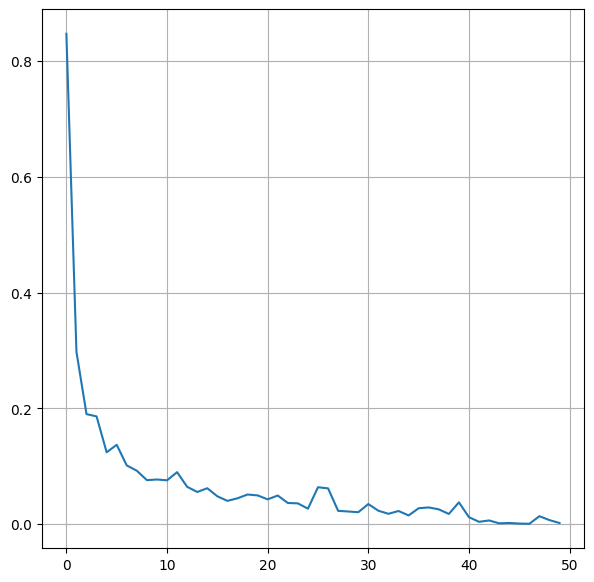

In [26]:
plt.figure(figsize=(7,7)) 
plt.grid() 
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.ylabel('Loss') 
#plt.xlabel('Epochs') 
#plt.legend(['Training','Validation'], loc='upper right') 
#plt.savefig("loss_curve.pdf") 
#plt.show()
#plt.figure(figsize=(5,5)) 
#plt.ylim(0,1.1) 
#plt.grid() 
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.ylabel('Accuracy') 
#plt.xlabel('Epochs') 
#plt.legend(['Training','Validation']) 
#plt.savefig("acc_curve.pdf") 
#plt.show()

In [27]:
# load best weights
model.load_weights("best-model_PU_3DCNN_HSI_ip.keras")
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [28]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(51423, 12, 12, 3, 1)

In [29]:
ytest = to_categorical(ytest)
ytest.shape

(51423, 16)

In [ ]:
start_time = time.time()

Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

end_time = time.time()  # End timing
test_time = end_time - start_time  # Calculate the test time
print(f'Test time: {test_time:.2f} seconds')

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

1605/1607 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

In [ ]:
# Overall Accuracy
oa = accuracy_score(np.argmax(ytest, axis=1), y_pred_test)

# Confusion Matrix
cm = confusion_matrix(np.argmax(ytest, axis=1), y_pred_test)
# Calculate per-class accuracy from the confusion matrix
class_accuracy = cm.diagonal() / cm.sum(axis=1)
# Average Accuracy
aa = np.mean(class_accuracy)

# Kappa Coefficient
kappa = cohen_kappa_score(np.argmax(ytest, axis=1), y_pred_test)

print(f'Overall Accuracy (OA): {oa:.4f}')
print(f'Average Accuracy (AA): {aa:.4f}')
print(f'Kappa Coefficient: {kappa:.4f}')
for i, acc in enumerate(class_accuracy): print(f'Class {i+1} Accuracy: {acc:.4f}')